In [1]:
# Synthetic data generation for MDA
import numpy as np

rng = np.random.default_rng()

# ----- controls -----
C, n = 2, 200

# ----- spherical Gaussian parameters -----
pi = np.repeat(1.0 / C, C)
mus = np.array([[-3.0, 0.0],
                [ 3.0, 0.0]], dtype=float)
sigma = 1.0
Sigma = (sigma ** 2) * np.eye(2)

# mixture setup for one class
mix_class = 0
mix_weights = np.array([0.8, 0.2])
mix_offsets = np.array([[-2.0, 2.0],
                        [ 2.0,-2.0]])
mix_mus = mus[mix_class] + mix_offsets

ys = rng.choice(C, size=n, p=pi)
X = []
for y in ys:
    if y == mix_class:
        k = rng.choice(len(mix_weights), p=mix_weights)
        X.append(rng.multivariate_normal(mix_mus[k], Sigma))
    else:
        X.append(rng.multivariate_normal(mus[y], Sigma))
X = np.vstack(X)


LDA step  400 | nll=3.1554
LDA step  800 | nll=2.6602
LDA step 1200 | nll=2.4815
LDA step 1600 | nll=2.4201
LDA step 2000 | nll=2.4166
MDA step  400 | nll=2.1455
MDA step  800 | nll=2.1381
MDA step 1200 | nll=2.1380
MDA step 1600 | nll=2.1380
MDA step 2000 | nll=2.1380
mixture probabilities per class/component: [[7.8373694e-01 2.1626301e-01]
 [5.8579979e-05 9.9994147e-01]]


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


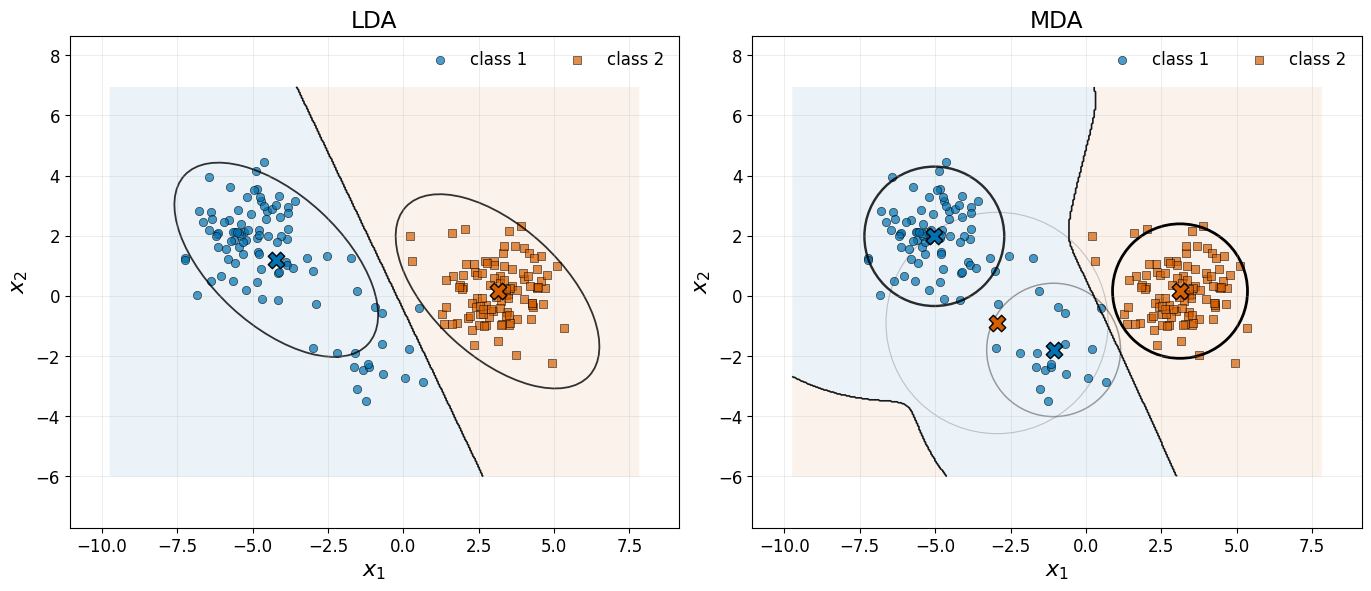

In [2]:
# LDA + MDA fit: spherical covariance
import numpy as np
import torch
from dnll import LDAHead, MDAHead, DNLLLoss, EM_DNLLLoss

X = X.astype(np.float32)
y = ys.astype(int)
C = int(np.max(y)) + 1
K = 2
D = X.shape[1]

Xt = torch.tensor(X, dtype=torch.float32)
yt = torch.tensor(y, dtype=torch.long)

# ----- LDA fit -----
lda = LDAHead(C, D, covariance_type="full").to(Xt.device)
opt_lda = torch.optim.Adam(lda.parameters(), lr=5e-2)
loss_fn_lda = DNLLLoss(lambda_reg=1.0)

for step in range(2000):
    loss = loss_fn_lda(lda(Xt), yt)
    opt_lda.zero_grad(set_to_none=True)
    loss.backward()
    opt_lda.step()
    if (step + 1) % 400 == 0:
        print(f"LDA step {step+1:4d} | nll={loss.item():.4f}")

# ----- MDA fit: 2 components per class, spherical covariance -----
mda = MDAHead(C, D, K).to(Xt.device)
opt_mda = torch.optim.Adam(mda.parameters(), lr=5e-2)
loss_fn_mda = EM_DNLLLoss(lambda_reg=1.0)

for step in range(2000):
    loss = loss_fn_mda(mda, Xt, yt)
    opt_mda.zero_grad(set_to_none=True)
    loss.backward()
    opt_mda.step()
    if (step + 1) % 400 == 0:
        print(f"MDA step {step+1:4d} | nll={loss.item():.4f}")

with torch.no_grad():
    lda_mu = lda.mu.detach().cpu().numpy()
    lda_Sigma = lda.covariance.detach().cpu().numpy()

    mix_probs = torch.softmax(mda.mixture_logits, dim=-1).cpu().numpy()
    print("mixture probabilities per class/component:", mix_probs)
    mda_mu = mda.mu.detach().cpu().numpy()
    log_cov = mda.log_cov.detach().cpu().numpy()
    var = np.exp(log_cov)
    mda_Sigma = var[..., None, None] * np.eye(D)

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

OKABE_ITO = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9",
             "#E69F00", "#000000", "#F0E442"]
colors = OKABE_ITO[:C]
markers = ["o", "s", "^"]
linestyles = ["-", "-"]

def cov_ellipse(mean, cov, k=2.0, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    width, height = 2 * k * np.sqrt(vals)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    return Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)

plt.rcParams.update({
    "font.size": 14, "axes.labelsize": 16, "legend.fontsize": 12,
    "xtick.labelsize": 12, "ytick.labelsize": 12
})

# decision regions shared grid
pad = 2.5
xmin, xmax = X[:,0].min()-pad, X[:,0].max()+pad
ymin, ymax = X[:,1].min()-pad, X[:,1].max()+pad
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 400),
                     np.linspace(ymin, ymax, 400))
grid = np.c_[xx.ravel(), yy.ravel()]
region_cmap = plt.matplotlib.colors.ListedColormap(colors)

fig, axes = plt.subplots(1, 2, figsize=(13.6, 5.8), constrained_layout=True)

def plot_regions(ax, model, title):
    with torch.no_grad():
        g = model(torch.tensor(grid, dtype=torch.float32)).cpu().numpy()
    pred = g.argmax(axis=1).reshape(xx.shape)
    ax.contourf(xx, yy, pred, levels=np.arange(C+1)-0.5,
                cmap=region_cmap, alpha=0.08, antialiased=True)
    ax.contour(xx, yy, pred, levels=np.arange(C+1)-0.5,
               colors="black", linewidths=1.2, alpha=0.9)
    for c in range(C):
        idx = (y == c)
        ax.scatter(X[idx, 0], X[idx, 1], s=36, c=colors[c], marker=markers[c],
                   edgecolors="black", linewidths=0.5, alpha=0.7, label=f"class {c+1}")
    ax.set_title(title)
    ax.set_xlabel(r"$x_1$")
    ax.set_ylabel(r"$x_2$")
    ax.legend(frameon=False, ncol=3, loc="upper right")
    ax.axis("equal")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(True, linewidth=0.4, alpha=0.4)

# LDA subplot
plot_regions(axes[0], lda, "LDA")
for c in range(C):
    axes[0].add_patch(cov_ellipse(lda_mu[c], lda_Sigma, k=2.15,
                                 edgecolor="black", facecolor="none",
                                 lw=1.3, linestyle="-", alpha=0.8))
    axes[0].scatter(lda_mu[c, 0], lda_mu[c, 1],
                    s=140, marker="X", c=colors[c], edgecolors="black",
                    linewidths=1.0, zorder=7)

# MDA subplot
plot_regions(axes[1], mda, "MDA")
for c in range(C):
    for k in range(K):
        weight = mix_probs[c, k]
        alpha = 0.2 + 0.8 * weight
        lw = 0.8 + 1.2 * weight
        axes[1].add_patch(cov_ellipse(mda_mu[c, k], mda_Sigma[c, k], k=2.15,
                                     edgecolor="black", facecolor="none",
                                     lw=lw, linestyle=linestyles[k], alpha=alpha))
        axes[1].scatter(mda_mu[c, k, 0], mda_mu[c, k, 1],
                        s=140, marker="X", c=colors[c], edgecolors="black",
                        linewidths=1.0, zorder=7)

plt.savefig("lda_mda_spherical_cov.png", dpi=600)
plt.show()
